In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from rl4co.envs import SLAPEnv
from rl4co.envs.warehousing.slap.generator import SLAPGenerator
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer

C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\torchrl\data\replay_buffers\samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)
C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\fabric\__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\fabric\__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa

In [2]:
class SLAPInitEmbedding(nn.Module):
    """Initial embedding 
    Embed the following node features to the embedding space:
        - locs: x, y coordinates of the nodes (cells)
        - probe: index of the (single) probe cell. We embed the euclidean distance from the probe to all cells.
    """

    def __init__(self, embed_dim, linear_bias=True):
        super(SLAPInitEmbedding, self).__init__()
        node_dim = 2  # x, y
        self.init_embed = self.init_embed = nn.Linear(node_dim, embed_dim, linear_bias)  # locs
        self.init_freq = nn.Linear(1, embed_dim, linear_bias)
        #self.init_embed_probe = nn.Linear(1, embed_dim // 2, linear_bias)  # probe

    def forward(self, td):
        # node_embeddings = self.init_embed(td["locs"])
        node_embeddings = self.init_embed(td["locs"])        

        return node_embeddings
    
    def _distance_depot(self, locs, depot):
        # Euclidean distance from probe to all locations
        probe_loc = torch.gather(locs, 1, depot.unsqueeze(-1).expand(-1, -1, 2))
        return torch.norm(locs - probe_loc, dim=-1).unsqueeze(-1)
        
    @staticmethod
    def _get_distance_matrix(locs: torch.Tensor):
        """Compute the Manhattan distance matrix for the given coordinates.

        Args:
            locs: Tensor of shape [..., n, dim]
        """
        if locs.dtype != torch.float32 and locs.dtype != torch.float64:
            locs = locs.to(torch.float32)

            # Compute pairwise differences
        diff = locs[..., :, None, :] - locs[..., None, :, :]

        # Compute Manhattan distance
        distance_matrix = torch.sum(torch.abs(diff), dim=-1)
        return distance_matrix

    

In [3]:
from rl4co.models.nn.env_embeddings.context import EnvContext


class SLAPContext(EnvContext):
    """Context embedding for the Decap Placement Problem (DPP), EDA (electronic design automation).
    Project the following to the embedding space:
        - current cell embedding
    """

    def __init__(self, embed_dim):
        super(SLAPContext, self).__init__(embed_dim)

    def forward(self, embeddings, td):
        """Context cannot be defined by a single node embedding for DPP, hence 0.
        We modify the dynamic embedding instead to capture placed items
        """
        # cur_node_embedding = self._cur_node_embedding(embeddings, td).squeeze()
        # print(cur_node_embedding)
        # print(cur_node_embedding.shape)
        # return self.project_context(cur_node_embedding)
        return embeddings.new_zeros(embeddings.size(0), self.embed_dim)

In [4]:
class StaticEmbedding(nn.Module):
    def __init__(self, *args, **kwargs):
        super(StaticEmbedding, self).__init__()

    def forward(self, td):
        return 0, 0, 0

In [5]:
env = SLAPEnv(generator_params={'n_aisles': 10,
                                'n_locs': 10})

In [6]:
from rl4co.models import AttentionModel
emb_dim = 128
policy = AttentionModelPolicy(env_name=env.name, # this is actually not needed since we are initializing the embeddings!
                              embed_dim=emb_dim,
                              init_embedding=SLAPInitEmbedding(emb_dim),
                              context_embedding=SLAPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)

model = AttentionModel(env, 
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_000,
                       val_data_size=10_000)

C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [7]:
from rl4co.models import PPO

model = PPO(env, policy)

Problem 1 | Cost: 1103.731


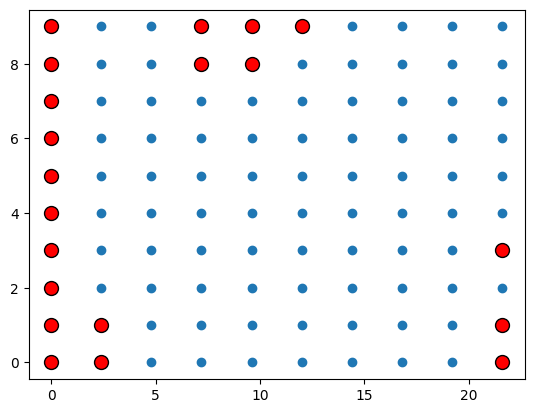

Problem 2 | Cost: 1179.094


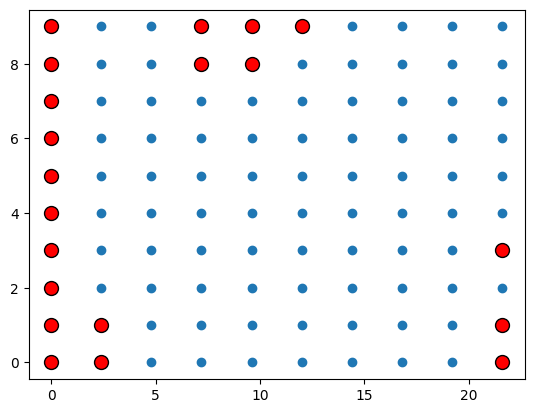

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[2]).to(device)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(2):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions=actions_untrained[i])

In [79]:
trainer = RL4COTrainer(max_epochs=1, devices="auto")
trainer.fit(model)

C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\accelerator_connector.py:512: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Overridi